----------------------------
# Session 2
----------------------------

In [ ]:
%matplotlib inline
import torch
import numpy as np
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Device : {device}")

Device : cuda


## Linear regression using PyTorch built-ins

We've implemented linear regression & gradient descent model using some basic tensor operations. However, since this is a common pattern in deep learning, PyTorch provides several built-in functions and classes to make it easy to create and train models with just a few lines of code.

Let's begin by importing the `torch.nn` package from PyTorch, which contains utility classes for building neural networks.

In [ ]:
import torch.nn as nn

### Dataset and DataLoader

We'll create a `TensorDataset`, which allows access to rows from `inputs` and `targets` as tuples, and provides standard APIs for working with many different types of datasets in PyTorch.

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
#@title  the dataset as simple tensors
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [74, 66, 43],
                   [91, 87, 65],
                   [88, 134, 59],
                   [101, 44, 37],
                   [68, 96, 71],
                   [73, 66, 44],
                   [92, 87, 64],
                   [87, 135, 57],
                   [103, 43, 36],
                   [68, 97, 70]],
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70],
                    [81, 101],
                    [119, 133],
                    [22, 37],
                    [103, 119],
                    [57, 69],
                    [80, 102],
                    [118, 132],
                    [21, 38],
                    [104, 118],
                    [57, 69],
                    [82, 100],
                    [118, 134],
                    [20, 38],
                    [102, 120]],
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
# Define the dataset based on the Dataset interface
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

The `TensorDataset` allows us to access a small section of the training data using the array indexing notation (`[0:3]` in the above code). It returns a tuple with two elements. The first element contains the input variables for the selected rows, and the second contains the targets.

We'll also create a `DataLoader`, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

We can use the data loader in a `for` loop. Let's look at an example.

In [ ]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 74.,  66.,  43.],
        [ 69.,  96.,  70.],
        [ 91.,  88.,  64.],
        [101.,  44.,  37.],
        [ 92.,  87.,  64.]])
tensor([[ 57.,  69.],
        [103., 119.],
        [ 81., 101.],
        [ 21.,  38.],
        [ 82., 100.]])


In each iteration, the data loader returns one batch of data with the given batch size. If `shuffle` is set to `True`, it shuffles the training data before creating batches. Shuffling helps randomize the input to the optimization algorithm, leading to a faster reduction in the loss.

### nn.Linear

Instead of initializing the weights & biases manually, we can define the model using the `nn.Linear` class from PyTorch, which does it automatically.

In [ ]:
# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.2630,  0.2245, -0.3768],
        [ 0.3735,  0.0934, -0.5418]], requires_grad=True)
Parameter containing:
tensor([-0.2727,  0.5201], requires_grad=True)


PyTorch models also have a helpful `.parameters` method, which returns a list containing all the weights and bias matrices present in the model. For our linear regression model, we have one weight matrix and one bias matrix.

In [ ]:
# Parameters
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2630,  0.2245, -0.3768],
         [ 0.3735,  0.0934, -0.5418]], requires_grad=True),
 Parameter containing:
 tensor([-0.2727,  0.5201], requires_grad=True)]

We can use the model to generate predictions in the same way as before.

In [ ]:
# Generate predictions
preds = model(inputs)
preds

tensor([[17.7689, 10.7491],
        [19.3058,  8.0565],
        [30.8418, 14.1089],
        [22.2690, 22.5913],
        [13.0547, -2.6651],
        [17.8074, 11.0292],
        [18.7045,  7.4213],
        [30.7280, 13.9406],
        [22.2305, 22.3112],
        [12.4149, -3.5805],
        [17.1676, 10.1139],
        [19.3443,  8.3367],
        [31.4431, 14.7440],
        [22.9088, 23.5067],
        [13.0162, -2.9453]], grad_fn=<AddmmBackward0>)

### Loss Function

Instead of defining a loss function manually, we can use the built-in loss function `mse_loss`.

In [ ]:
# Import nn.functional
import torch.nn.functional as F

The `nn.functional` package contains many useful loss functions and several other utilities.

In [ ]:
# Define loss function
loss_fn = F.mse_loss

Let's compute the loss for the current predictions of our model.

In [ ]:
loss = loss_fn(model(inputs), targets)
print(loss)

tensor(6244.7715, grad_fn=<MseLossBackward0>)


### Optimizer

Instead of manually manipulating the model's weights & biases using gradients, we can use the optimizer `optim.SGD`. SGD is short for "stochastic gradient descent". The term _stochastic_ indicates that samples are selected in random batches instead of as a single group. Since the group can be larger than a single element, it corresponds to SGD with _minibatch_. In fact, the `optimizer` is not responsible for loading batches, as this aspect is handled by the `DataLoader`.

In [ ]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

Note that `model.parameters()` is passed as an argument to `optim.SGD` so that the optimizer knows which matrices should be modified during the update step. Also, we can specify a learning rate that controls the amount by which the parameters are modified.

## Exercise 1: Train the model

We are now ready to train the model. We'll follow the same process to implement gradient descent:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

The only change is that we'll work batches of data instead of processing the entire training data in every iteration. Let's define a utility function `fit` that trains the model for a given number of epochs.

In [ ]:
# Utility function to train the model
def train_with_MiniBatchSGD(num_epochs, model, loss_fn, opt, train_dl):

    # Repeat for given number of epochs
    for epoch in range(num_epochs):

        # Train with batches of data
        for xb,yb in train_dl:

            # 1. Generate predictions
            pred = model(xb)

            # 2. Calculate loss
            loss = loss_fn(pred, yb)

            # 3. Compute gradients
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero
            opt.zero_grad()

        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Some things to note above:

* We use the data loader defined earlier to get batches of data for every iteration.

* Instead of updating parameters (weights and biases) manually, we use `opt.step` to perform the update and `opt.zero_grad` to reset the gradients to zero.

* We've also added a log statement that prints the loss from the last batch of data for every 10th epoch to track training progress. `loss.item` returns the actual value stored in the loss tensor.

Let's train the model for 100 epochs.

In [ ]:
train_with_MiniBatchSGD(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 115.3719
Epoch [20/100], Loss: 52.2937
Epoch [30/100], Loss: 40.8736
Epoch [40/100], Loss: 51.4276
Epoch [50/100], Loss: 29.2011
Epoch [60/100], Loss: 42.5979
Epoch [70/100], Loss: 46.5801
Epoch [80/100], Loss: 25.6359
Epoch [90/100], Loss: 50.2568
Epoch [100/100], Loss: 24.5282


Let's generate predictions using our model and verify that they're close to our targets.

In [ ]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.4161,  71.1270],
        [ 78.7830,  96.1335],
        [124.6826, 141.4831],
        [ 23.5497,  41.1310],
        [ 94.5705, 108.9812],
        [ 56.1272,  69.9790],
        [ 78.0301,  95.4155],
        [124.6534, 141.6421],
        [ 24.8386,  42.2790],
        [ 95.1065, 109.4112],
        [ 56.6632,  70.4090],
        [ 77.4941,  94.9855],
        [125.4355, 142.2012],
        [ 23.0137,  40.7011],
        [ 95.8594, 110.1292]], grad_fn=<AddmmBackward0>)

In [ ]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 57.,  69.],
        [ 80., 102.],
        [118., 132.],
        [ 21.,  38.],
        [104., 118.],
        [ 57.,  69.],
        [ 82., 100.],
        [118., 134.],
        [ 20.,  38.],
        [102., 120.]])

Indeed, the predictions are quite close to our targets. We have a trained a reasonably good model to predict crop yields for apples and oranges by looking at the average temperature, rainfall, and humidity in a region. We can use it to make predictions of crop yields for new regions by passing a batch containing a single row of input.

In [ ]:
with torch.no_grad():
    print(model(torch.tensor([[75, 63, 44.]])))

tensor([[53.0792, 67.1005]])


## Training an MLP classifier on FashionMNIST
FashionMNIST is a classification benchmark, where images are associated to classes. In this exercise, you shall have to adapt the linear regression to this context. The main adaptation steps are as follows:
* Change the dataset (using TorchVision)
* Replace the mere linear model by an MLP
* Change the MSE loss to a CrossEntropy loss


### Working with data
Remember that PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
`TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset.
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |



Every TorchVision ``Dataset`` includes an argument: ``transform``
 to modify the samples.




In [ ]:
# Import TorchVision utilities
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.2MB/s]


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Get one batch of data and print its tensor shape
X,y = next(iter(train_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


--------------




## Exercise 2: Creating  the MLP model

To define a MLP, you may rely on `nn.Sequential <https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>`. It implements a sequential container modules made from a sequence of `nn.Module`. The goal here is to have the following sequence:

$$
I\in\mathbb R^{28}\otimes\mathbb R^{28}  
\xrightarrow{\mathrm{flatten}}{} \mathbb R^{28\times 28}=\mathbb R^{784}
\xrightarrow{\mathrm{Linear+ReLU}}{} \mathbb R^{512}
\xrightarrow{\mathrm{Linear+ReLU}}{} \mathbb R^{512}
\xrightarrow{\mathrm{Linear}}{} \mathbb R^{n_c}
$$

You shall implement this archticture, and determine what is the logical value for $n_c$ in our settings.

In [ ]:
debug = False
# https://www.kaggle.com/datasets/zalando-research/fashionmnist
def create_MLP():
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
      nn.Linear(512, 10) # I used the documentation to see the quantity of labels
    ).to(device)

    return model

def test_exercise2():
    model = create_MLP()
    if not isinstance(model, nn.Sequential):
        print('Exercise 2: [NOK]')
        if debug:
            print(f'The model should be a nn.Sequential instance not {type(model)}')
        return

    if len(model) != 6:
        print('Exercise 2: [NOK]')
        if debug:
            print(f'The model should be 6 layers not {len(mode)}')
        return

    model_device = next(model.parameters()).device
    expected_device = torch.empty(1).to(device).device
    if model_device != expected_device:
        print('Exercise 2: [NOK]')
        if debug:
            print(f'The model should run on {expected_device} not on {model_device}')
        return

    X,y = next(iter(train_dataloader))
    pred = model(X.to(device))
    expected_shape = torch.Size((batch_size, 10))
    if pred.shape != expected_shape:
        print('Exercise 2: [NOK]')
        if debug:
            print(f'The model predictions should be shaped as {expected_shape} not as {pred.shape}')
        return

    print('Exercise 2: [OK]')

    if debug:
        print(model)

test_exercise2()

Exercise 2: [OK]


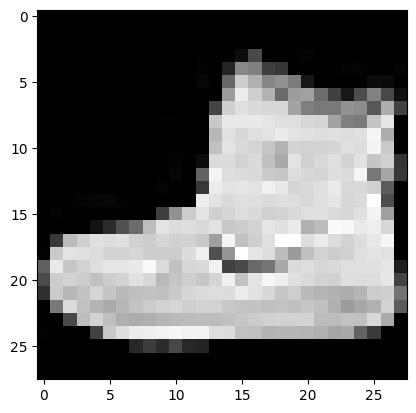

Label: 9


In [ ]:
import matplotlib.pyplot as plt

img, label = training_data[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {label}")

--------------




## Exercise 3: Defining the loss function.
To train a model, we need a `loss function <https://pytorch.org/docs/stable/nn.html#loss-functions>`.
The MSE loss is not the usually selected one for classification problems. You should propose a better suited loss.



In [ ]:
from torch.nn import CrossEntropyLoss

def create_loss():
    loss_fn = CrossEntropyLoss() # The question command say us to use it
    return loss_fn

def test_exercise3():
    loss_fn = create_loss()
    if loss_fn is None:
        print('Exercise 3: [NOK]')
        if debug:
            print(f'The loss should be {expected_loss} not as {loss}')
        return
    y = torch.arange(1,dtype=torch.long).to(device)
    pred = torch.ones((1,10),dtype=float).to(device)
    loss = loss_fn(pred, y).item()
    expected_loss = np.log(10) # entropy of a random [0-9] source
    if abs(loss-expected_loss) > 1e-5:
        print('Exercise 3: [NOK]')
        if debug:
            print(f'The loss should be {expected_loss} not as {loss}')
        return

    print('Exercise 3: [OK]')

test_exercise3()


Exercise 3: [OK]


### Exercise 4: Performing the optimization
Getting inspired by the [Linear Regression example](#scrollTo=s4G-FSTAnTT8), complete the following function (single epoch) and launch the whole training procedure (remaining cells).


In [ ]:
def perform_one_epoch(dataloader, model, loss_fn, optimizer):
  model.to(device)
  model.train()
  for X, y in dataloader:
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 10
model = create_MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = create_loss()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    perform_one_epoch(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 51.1%, Avg loss: 2.148071 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.860696 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 60.7%, Avg loss: 1.495243 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.239089 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.3%, Avg loss: 1.079451 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 65.5%, Avg loss: 0.976410 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 66.9%, Avg loss: 0.906264 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 68.1%, Avg loss: 0.855700 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 69.3%, Avg loss: 0.817280 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.786576 

Done!


### Exercise 5: Variants on Fashion Mnist
In this exercise you will replace the MLP model by variants of the following CNN architecture.
$$
I\in\mathbb R^{28}\otimes\mathbb R^{28}  
\xrightarrow{\mathrm{Conv3x3+ReLU+Pool}}{} \mathbb R^{14}\otimes\mathbb R^{14}\otimes\mathbb R^{64}
\xrightarrow{\mathrm{Conv3x3+ReLU+Pool}}{} \mathbb R^{7}\otimes\mathbb R^{7}\otimes\mathbb R^{64}
\xrightarrow{\mathrm{Conv3x3+ReLU+Flatten}}{} \mathbb R^{490}
\xrightarrow{\mathrm{Linear}}{} \mathbb R^{n_c}
$$

You may consider the following variants:
* Max vs Avg Pooling,
* changing the padding of the convolutions,
* changing 3x3 conv by larger or smaller convolutions
* Playing with the number of channels of the hidden layers

You will compare the different variants in terms of :
* Classification accuracy
* Computation throughput
* Memory footprint both in terms of number of parameters, and activation maps

In [ ]:
def create_MLP():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(7*7*64, 10)
    ).to(device)
    return model

epochs = 10
model = create_MLP()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = create_loss()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    perform_one_epoch(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 45.8%, Avg loss: 2.044555 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 65.6%, Avg loss: 0.919291 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.812974 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 71.3%, Avg loss: 0.766713 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.738716 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.718247 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.701338 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.685492 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.670251 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.655720 

Done!
